# Preparing Textual Data

```{note}
Install ekorpkit package first.
Set logging level to Warning, if you don't want to see verbose logging,
```

In [1]:
%config InlineBackend.figure_format='retina'
from ekorpkit import eKonf

eKonf.setLogger("WARNING")
print("version:", eKonf.__version__)
print("is notebook?", eKonf.is_notebook())
print("is colab?", eKonf.is_colab())
print("evironment varialbles:")
eKonf.print(eKonf.env().dict())

INFO:ekorpkit.base:IPython version: (6, 9, 0), client: jupyter_client
INFO:ekorpkit.base:Google Colab not detected.


version: 0.1.35+0.g69734d6.dirty
is notebook? True
is colab? False
evironment varialbles:
{'CUDA_DEVICE_ORDER': None,
 'CUDA_VISIBLE_DEVICES': None,
 'EKORPKIT_CONFIG_DIR': '/workspace/projects/ekorpkit-book/config',
 'EKORPKIT_DATA_DIR': None,
 'EKORPKIT_LOG_LEVEL': 'WARNING',
 'EKORPKIT_PROJECT': 'ekorpkit-book',
 'EKORPKIT_WORKSPACE_ROOT': '/workspace',
 'KMP_DUPLICATE_LIB_OK': 'TRUE',
 'NUM_WORKERS': 230}


In [2]:
data_dir = "../data/fomc"

## Load FOMC corpus

In [3]:
cfg = eKonf.compose('corpus')
cfg.name = 'fomc'
cfg.path.cache.uri = 'https://github.com/entelecheia/ekorpkit-book/raw/main/assets/data/fomc.zip'
cfg.data_dir = cfg.path.cached_path
cfg.auto.merge = True
fomc_corpus = eKonf.instantiate(cfg)
print(fomc_corpus)

INFO:ekorpkit.base:IPython version: (6, 9, 0), client: jupyter_client


Corpus : fomc


## Load FOMC class

In [4]:
cfg = eKonf.compose("io/fetcher/fomc")
cfg.output_dir = data_dir
fomc = eKonf.instantiate(cfg)

In [5]:
fomc.load_calendar(from_year=1982, force_download=False)

,unscheduled,forecast,confcall,speaker,rate,rate_change,rate_decision,rate_changed
date,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.50,-0.50,-1.0,1
1982-11-16,False,False,False,Paul Volcker,9.00,-0.50,-1.0,1
1982-12-21,False,False,False,Paul Volcker,8.50,0.00,0.0,0
1983-01-14,False,False,True,Paul Volcker,8.50,0.00,0.0,0
1983-01-21,False,False,True,Paul Volcker,8.50,0.00,0.0,0
...,...,...,...,...,...,...,...,...
2021-11-03,False,False,False,Jerome Powell,0.25,0.00,0.0,0
2021-12-15,False,True,False,Jerome Powell,0.25,0.00,0.0,0
2022-01-26,False,False,False,Jerome Powell,0.25,0.00,0.0,0


## Postprocess metadata

In [8]:
# Postprocessing
fomc_data = fomc.postprocess_metadata(fomc_corpus.data)
fomc_data.tail()

,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate
2817,2850,CHAIR YELLEN. I’d like to begin by welcoming...,train,2014-06-18,fomc_meeting_script,2014-06-18,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-06-18,0.0,0.25,2014-07-30,0.0,0.25
2818,2851,"CHAIR YELLEN. Good morning, everybody. I wou...",train,2014-07-30,fomc_meeting_script,2014-07-30,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-07-30,0.0,0.25,2014-09-17,0.0,0.25
2819,2852,"CHAIR YELLEN. Good morning, everybody. Our fi...",train,2014-09-17,fomc_meeting_script,2014-09-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-09-17,0.0,0.25,2014-10-29,2.0,0.25
2820,2853,CHAIR YELLEN. I’d like to call this meeting t...,train,2014-10-29,fomc_meeting_script,2014-10-29,Janet Yellen,FOMC Meeting Transcript,2.0,0.25,2014-10-29,2.0,0.25,2014-12-17,0.0,0.25
2821,2854,"CHAIR YELLEN. Good afternoon, everyone. I th...",train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25


## Postprocess FOMC corpus

In [11]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
overrides=[
    '+pipeline=default',
    'pipeline/filter_length=words',
]
cfg = eKonf.compose("pipeline", overrides)
cfg._pipeline_ = ["filter_length", "save_dataframe"]
cfg.num_workers = 10
cfg.filter_length.min_length = 50
cfg.save_dataframe.output_dir = data_dir
cfg.save_dataframe.output_file = "fomc_corpus.parquet"
fomc_data = eKonf.instantiate(cfg, data=fomc_data)
fomc_data.tail()

INFO:ekorpkit.pipelines.pipe:Applying pipeline: OrderedDict([('filter_length', 'filter_length'), ('save_dataframe', 'save_dataframe')])
INFO:ekorpkit.base:Applying pipe: functools.partial(<function filter_length at 0x7fc2a666cf70>, len_bytes={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_bytes'}, len_words={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_words'})
INFO:ekorpkit.base:Using batcher with minibatch size: 13
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 13  procs: 230  input_split: False  merge_output: True  len(data): 2802 len(args): 5
Calculating length: 100%|██████████| 216/216 [00:04<00:00, 53.65it/s] 
INFO:ekorpkit.pipelines.pipe:removed 0 of 2802 documents with length < 50
INFO:ekorpkit.pipelines.pipe: >> elapsed time to filter length: 0:00:04.039304
INFO:ekorpkit.base:Applying pipe: functools.partial(<function save_dataframe at 0x7fc2a666d550>)
INFO:ekorpkit.io.file:Saving dataframe to ../data/fomc/fomc_corpus.parquet


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words
2817,2850,CHAIR YELLEN. I’d like to begin by welcoming...,train,2014-06-18,fomc_meeting_script,2014-06-18,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-06-18,0.0,0.25,2014-07-30,0.0,0.25,86489
2818,2851,"CHAIR YELLEN. Good morning, everybody. I wou...",train,2014-07-30,fomc_meeting_script,2014-07-30,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-07-30,0.0,0.25,2014-09-17,0.0,0.25,88197
2819,2852,"CHAIR YELLEN. Good morning, everybody. Our fi...",train,2014-09-17,fomc_meeting_script,2014-09-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-09-17,0.0,0.25,2014-10-29,2.0,0.25,61211
2820,2853,CHAIR YELLEN. I’d like to call this meeting t...,train,2014-10-29,fomc_meeting_script,2014-10-29,Janet Yellen,FOMC Meeting Transcript,2.0,0.25,2014-10-29,2.0,0.25,2014-12-17,0.0,0.25,72240
2821,2854,"CHAIR YELLEN. Good afternoon, everyone. I th...",train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,58709


In [12]:
fomc_data = eKonf.load_data("fomc_corpus.parquet", data_dir)
fomc_data.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_corpus.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_corpus.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_corpus.parquet


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words
2817,2850,CHAIR YELLEN. I’d like to begin by welcoming...,train,2014-06-18,fomc_meeting_script,2014-06-18,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-06-18,0.0,0.25,2014-07-30,0.0,0.25,86489
2818,2851,"CHAIR YELLEN. Good morning, everybody. I wou...",train,2014-07-30,fomc_meeting_script,2014-07-30,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-07-30,0.0,0.25,2014-09-17,0.0,0.25,88197
2819,2852,"CHAIR YELLEN. Good morning, everybody. Our fi...",train,2014-09-17,fomc_meeting_script,2014-09-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-09-17,0.0,0.25,2014-10-29,2.0,0.25,61211
2820,2853,CHAIR YELLEN. I’d like to call this meeting t...,train,2014-10-29,fomc_meeting_script,2014-10-29,Janet Yellen,FOMC Meeting Transcript,2.0,0.25,2014-10-29,2.0,0.25,2014-12-17,0.0,0.25,72240
2821,2854,"CHAIR YELLEN. Good afternoon, everyone. I th...",train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,58709


INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/CountPlot.png


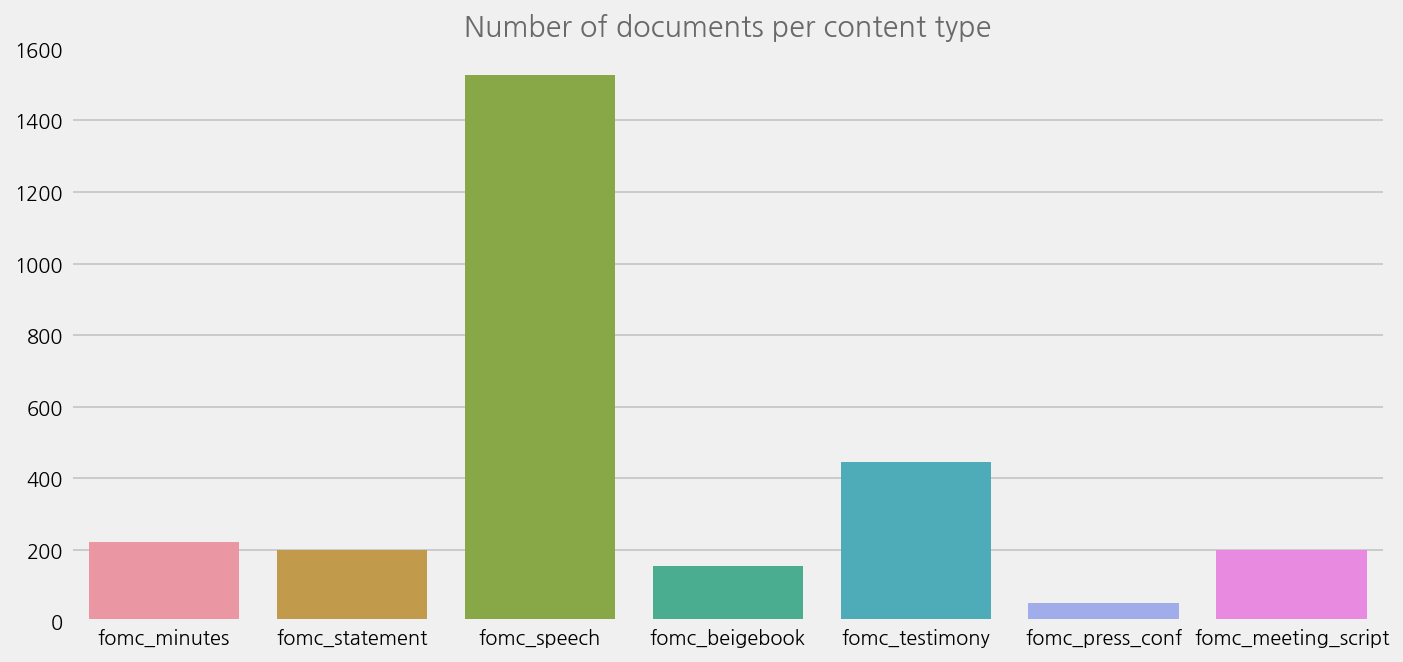

In [13]:
cfg = eKonf.compose("visualize/plot=countplot")
cfg.countplot.x = "content_type"
cfg.figure.figsize = (10, 5)
cfg.figure.fontsize = 10
cfg.ax.title = "Number of documents per content type"
eKonf.instantiate(cfg, data=fomc_data)

### Distribution of corpus

INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/HistPlot.png


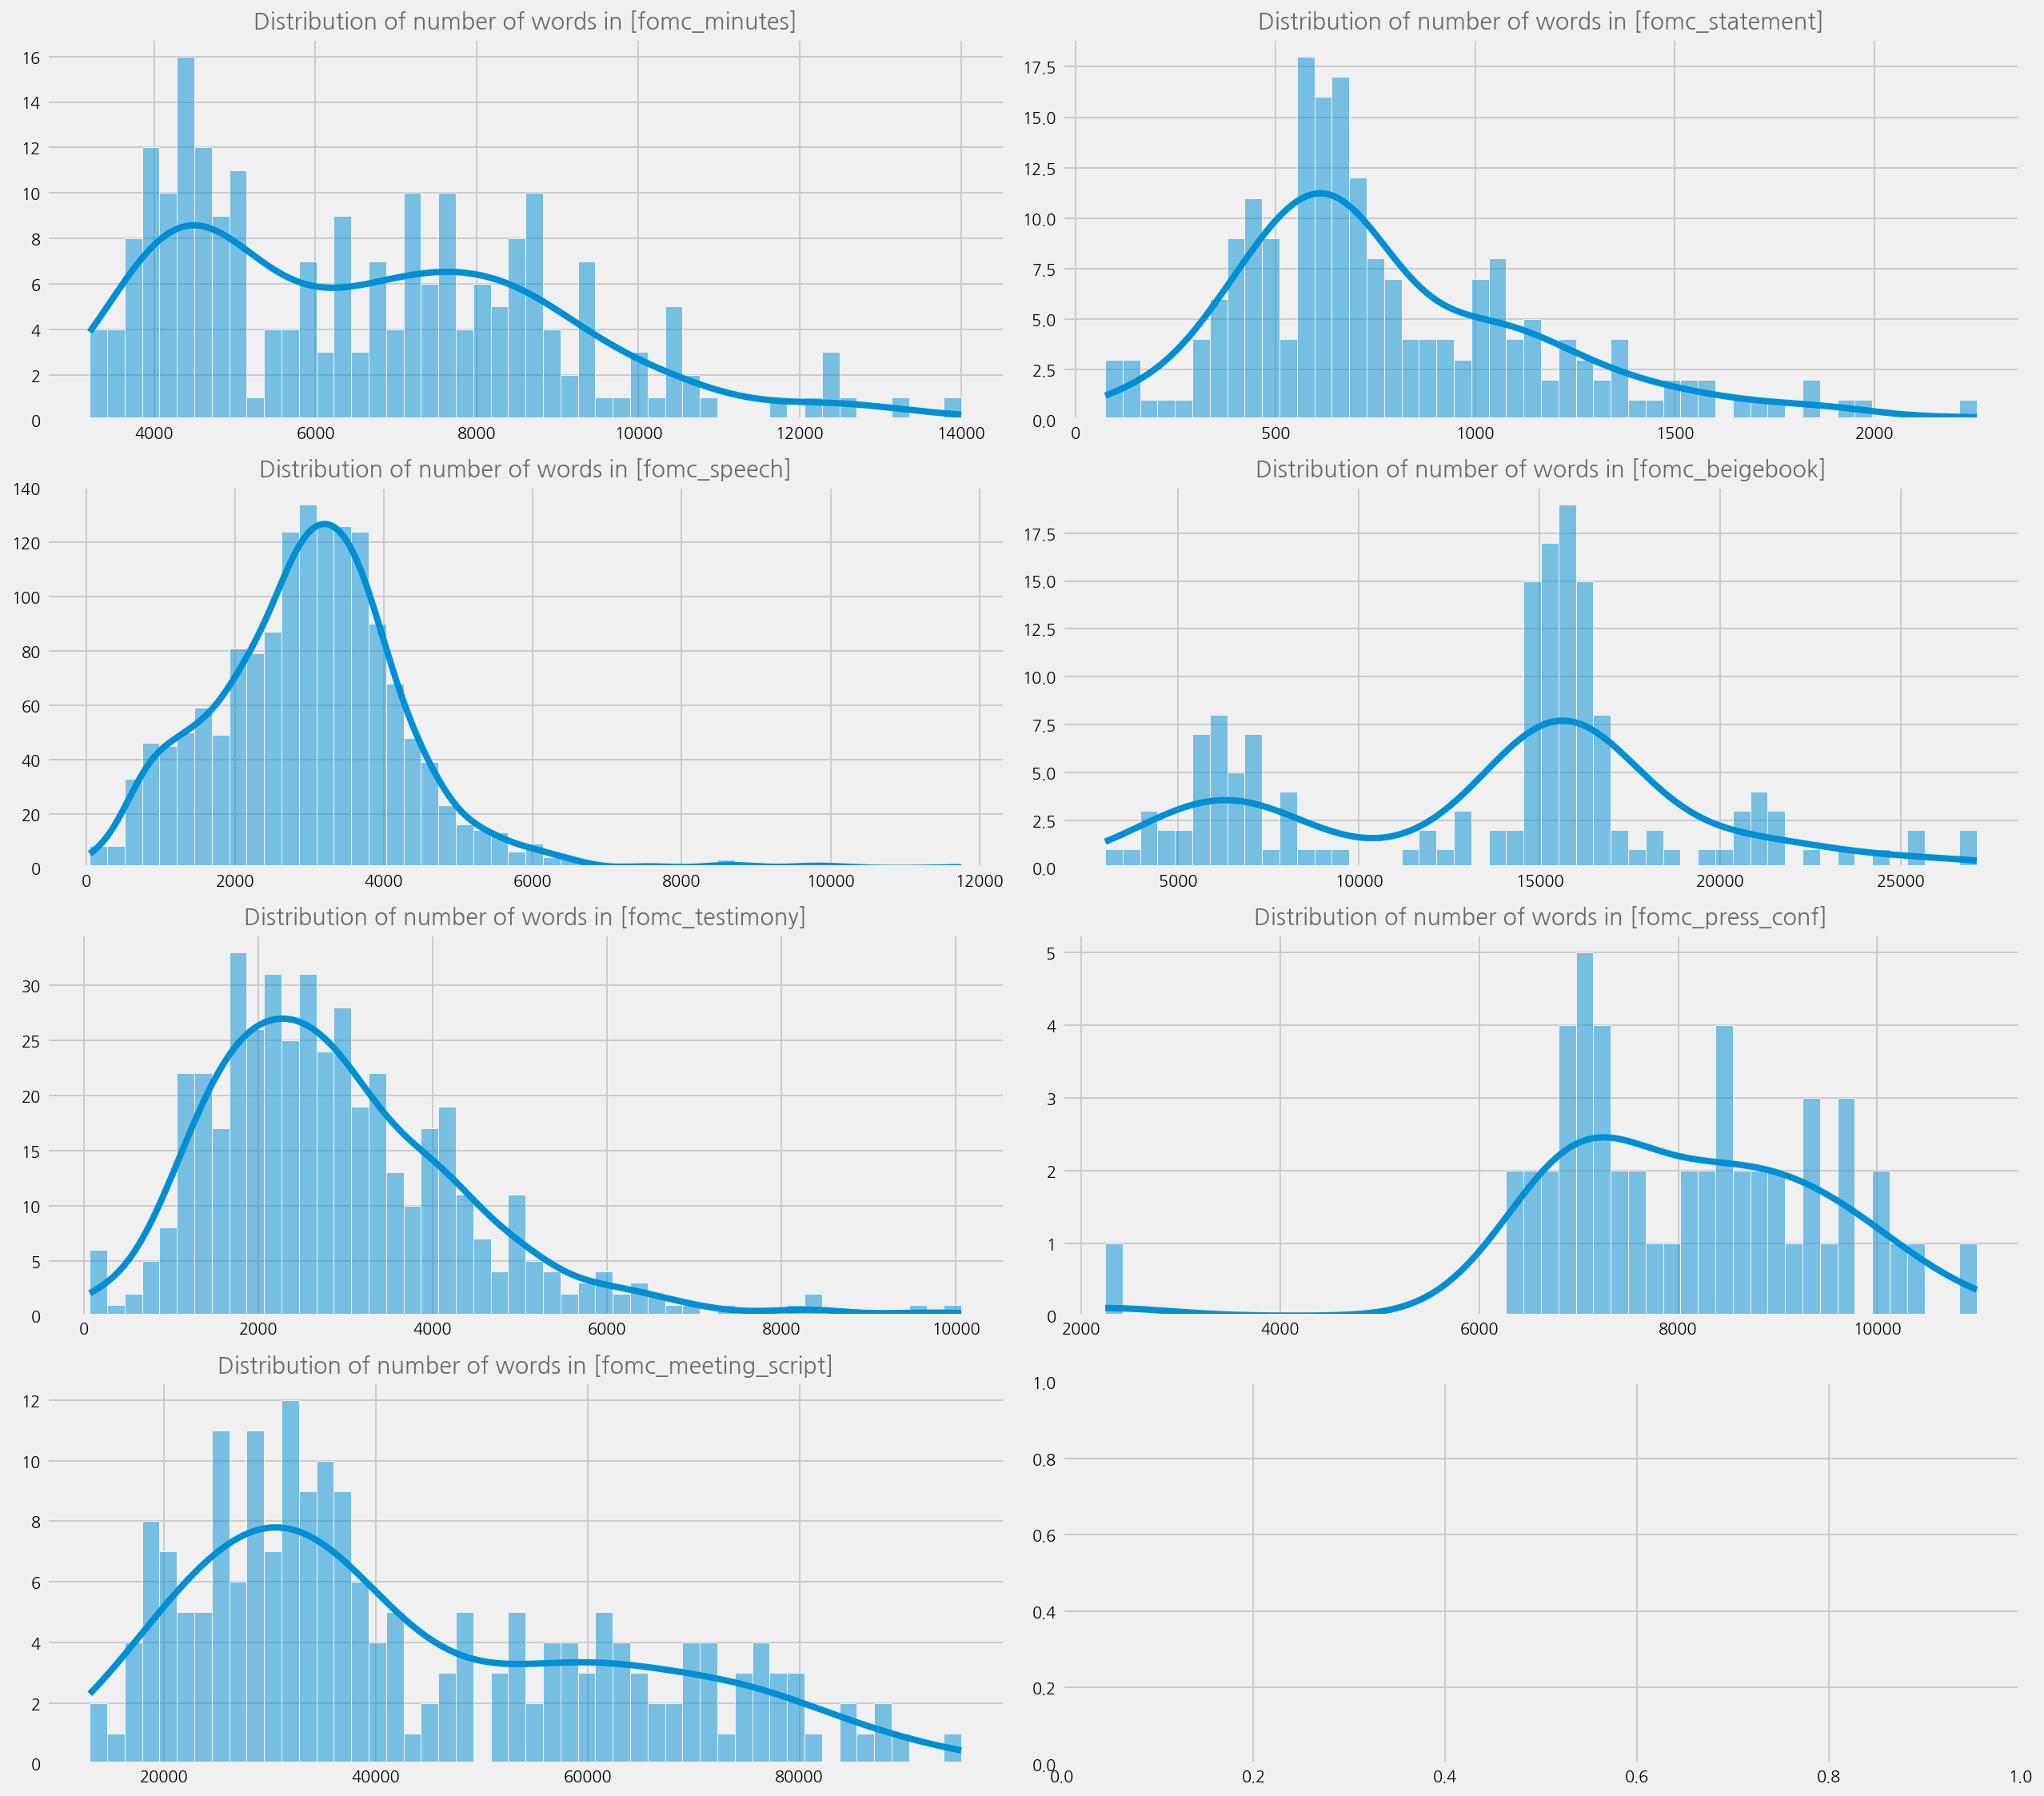

In [14]:
content_types = fomc_data.content_type.unique()

cfg = eKonf.compose("visualize/plot=histplot")
cfg.figure.figsize = (18, 16)
cfg.figure.fontsize = 10
cfg.subplots.ncols = 2
cfg.subplots.nrows = 4
ax = cfg.ax.copy()
histplot = cfg.histplot.copy()
histplot.x = "text_num_words"
histplot.bins = 50
histplot.kde = True
cfg.plots = [histplot.copy() for _ in range(len(content_types))]
cfg.axes = [ax.copy() for _ in range(len(content_types))]
for i, ctype in enumerate(content_types):
    plot = cfg.plots[i]
    plot.query = f"content_type == '{ctype}'"
    plot.axno = i
    ax = cfg.axes[i]
    ax.title =  f"Distribution of number of words in [{ctype}]"
    ax.axno = i

eKonf.instantiate(cfg, data=fomc_data)


## Split corpus into sections

In [15]:
cfg = eKonf.compose("pipeline")
cfg._pipeline_ = ["explode_splits", "filter_length", "reset_index", "save_dataframe"]
cfg.num_workers = 100
cfg.explode_splits.id_key = "id"
cfg.explode_splits.split_key = "section_id"
cfg.explode_splits.separator = "\n\n"
cfg.filter_length.min_length = 50
cfg.filter_length.len_func = "len_words"
cfg.filter_length.len_column = "num_words"
cfg.reset_index.drop_index = True
cfg.save_dataframe.output_dir = data_dir
cfg.save_dataframe.output_file = "fomc_sections.parquet"
fomc_sections = eKonf.instantiate(cfg, data=fomc_data)
fomc_sections.tail()

INFO:ekorpkit.pipelines.pipe:Applying pipeline: OrderedDict([('explode_splits', 'explode_splits'), ('filter_length', 'filter_length'), ('reset_index', 'reset_index'), ('save_dataframe', 'save_dataframe')])
INFO:ekorpkit.base:Applying pipe: functools.partial(<function explode_splits at 0x7fc2a666c820>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function filter_length at 0x7fc2a666cf70>, len_bytes={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_bytes'}, len_words={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_words'})
INFO:ekorpkit.base:Using batcher with minibatch size: 923
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 923  procs: 230  input_split: False  merge_output: True  len(data): 212170 len(args): 5
Calculating length: 100%|██████████| 230/230 [00:00<00:00, 431.45it/s]
INFO:ekorpkit.pipelines.pipe:removed 120119 of 212170 documents with length < 50
INFO:ekorpkit.pipelines.pipe: >> elapsed time to filter length: 0:00:00.560365
INFO

,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words,section_id
92046,2854,"MS. BRAINARD. Thank you. Since we last met, ...",train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,506,281
92047,2854,VICE CHAIRMAN DUDLEY. No worries. It happene...,train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,1446,285
92048,2854,CHAIR YELLEN. Thank you. Okay. I think the ...,train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,83,286
92049,2854,"MR. LUECKE. This vote, as Chair Yellen indica...",train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,73,287
92050,2854,CHAIR YELLEN. Okay. Thank you very much. An...,train,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,77,288


In [16]:
fomc_sections = fomc.find_speaker_of_sections(fomc_sections)
eKonf.save_data(fomc_sections, "fomc_sections.parquet", data_dir)

INFO:ekorpkit.io.file:Saving dataframe to ../data/fomc/fomc_sections.parquet


In [17]:
fomc_sections = eKonf.load_data("fomc_sections.parquet", data_dir)
fomc_sections.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sections.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_sections.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_sections.parquet


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words,section_id
92046,2854,"MS. BRAINARD. Thank you. Since we last met, ...",train,2014-12-17,fomc_meeting_script,2014-12-17,MS. BRAINARD,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,506,281
92047,2854,VICE CHAIRMAN DUDLEY. No worries. It happene...,train,2014-12-17,fomc_meeting_script,2014-12-17,VICE CHAIRMAN DUDLEY,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,1446,285
92048,2854,CHAIR YELLEN. Thank you. Okay. I think the ...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,83,286
92049,2854,"MR. LUECKE. This vote, as Chair Yellen indica...",train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,73,287
92050,2854,CHAIR YELLEN. Okay. Thank you very much. An...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,77,288


INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/CountPlot.png


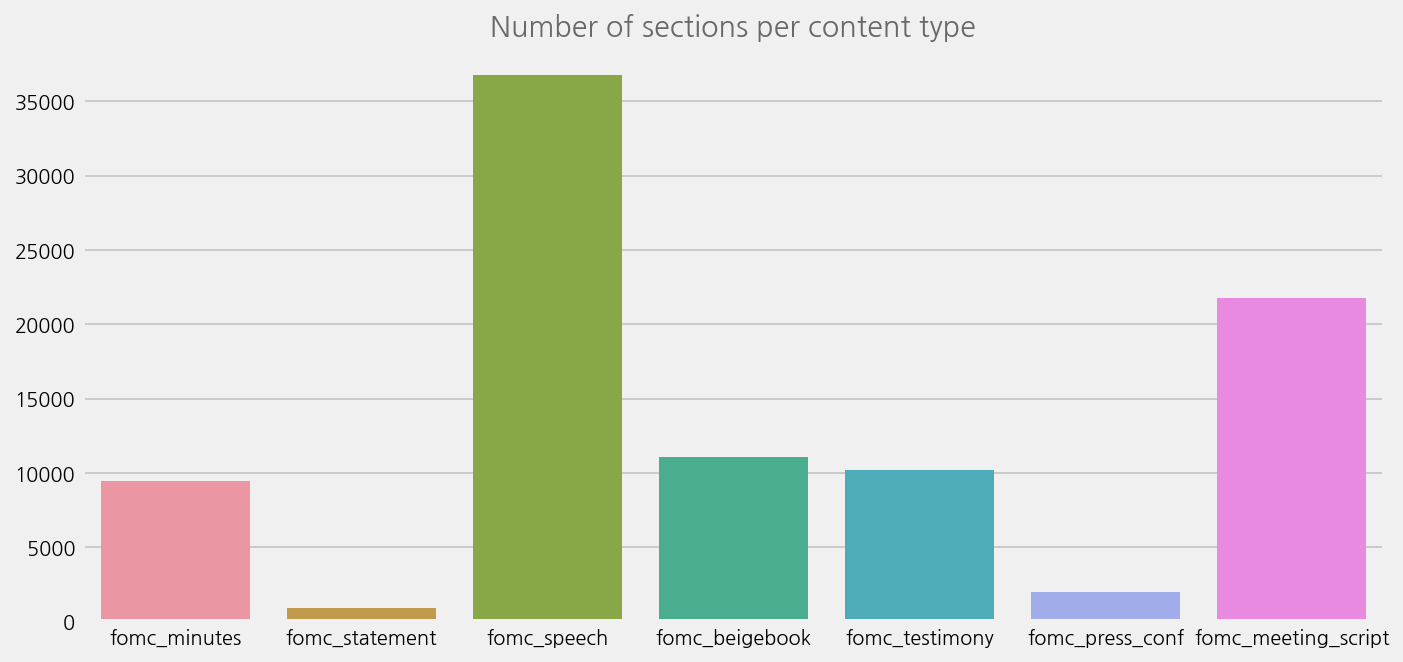

In [18]:
cfg = eKonf.compose("visualize/plot=countplot")
cfg.countplot.x = "content_type"
cfg.figure.figsize = (10, 5)
cfg.figure.fontsize = 10
cfg.ax.title = "Number of sections per content type"
eKonf.instantiate(cfg, data=fomc_sections)

### Distribution of sectons

INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/HistPlot.png


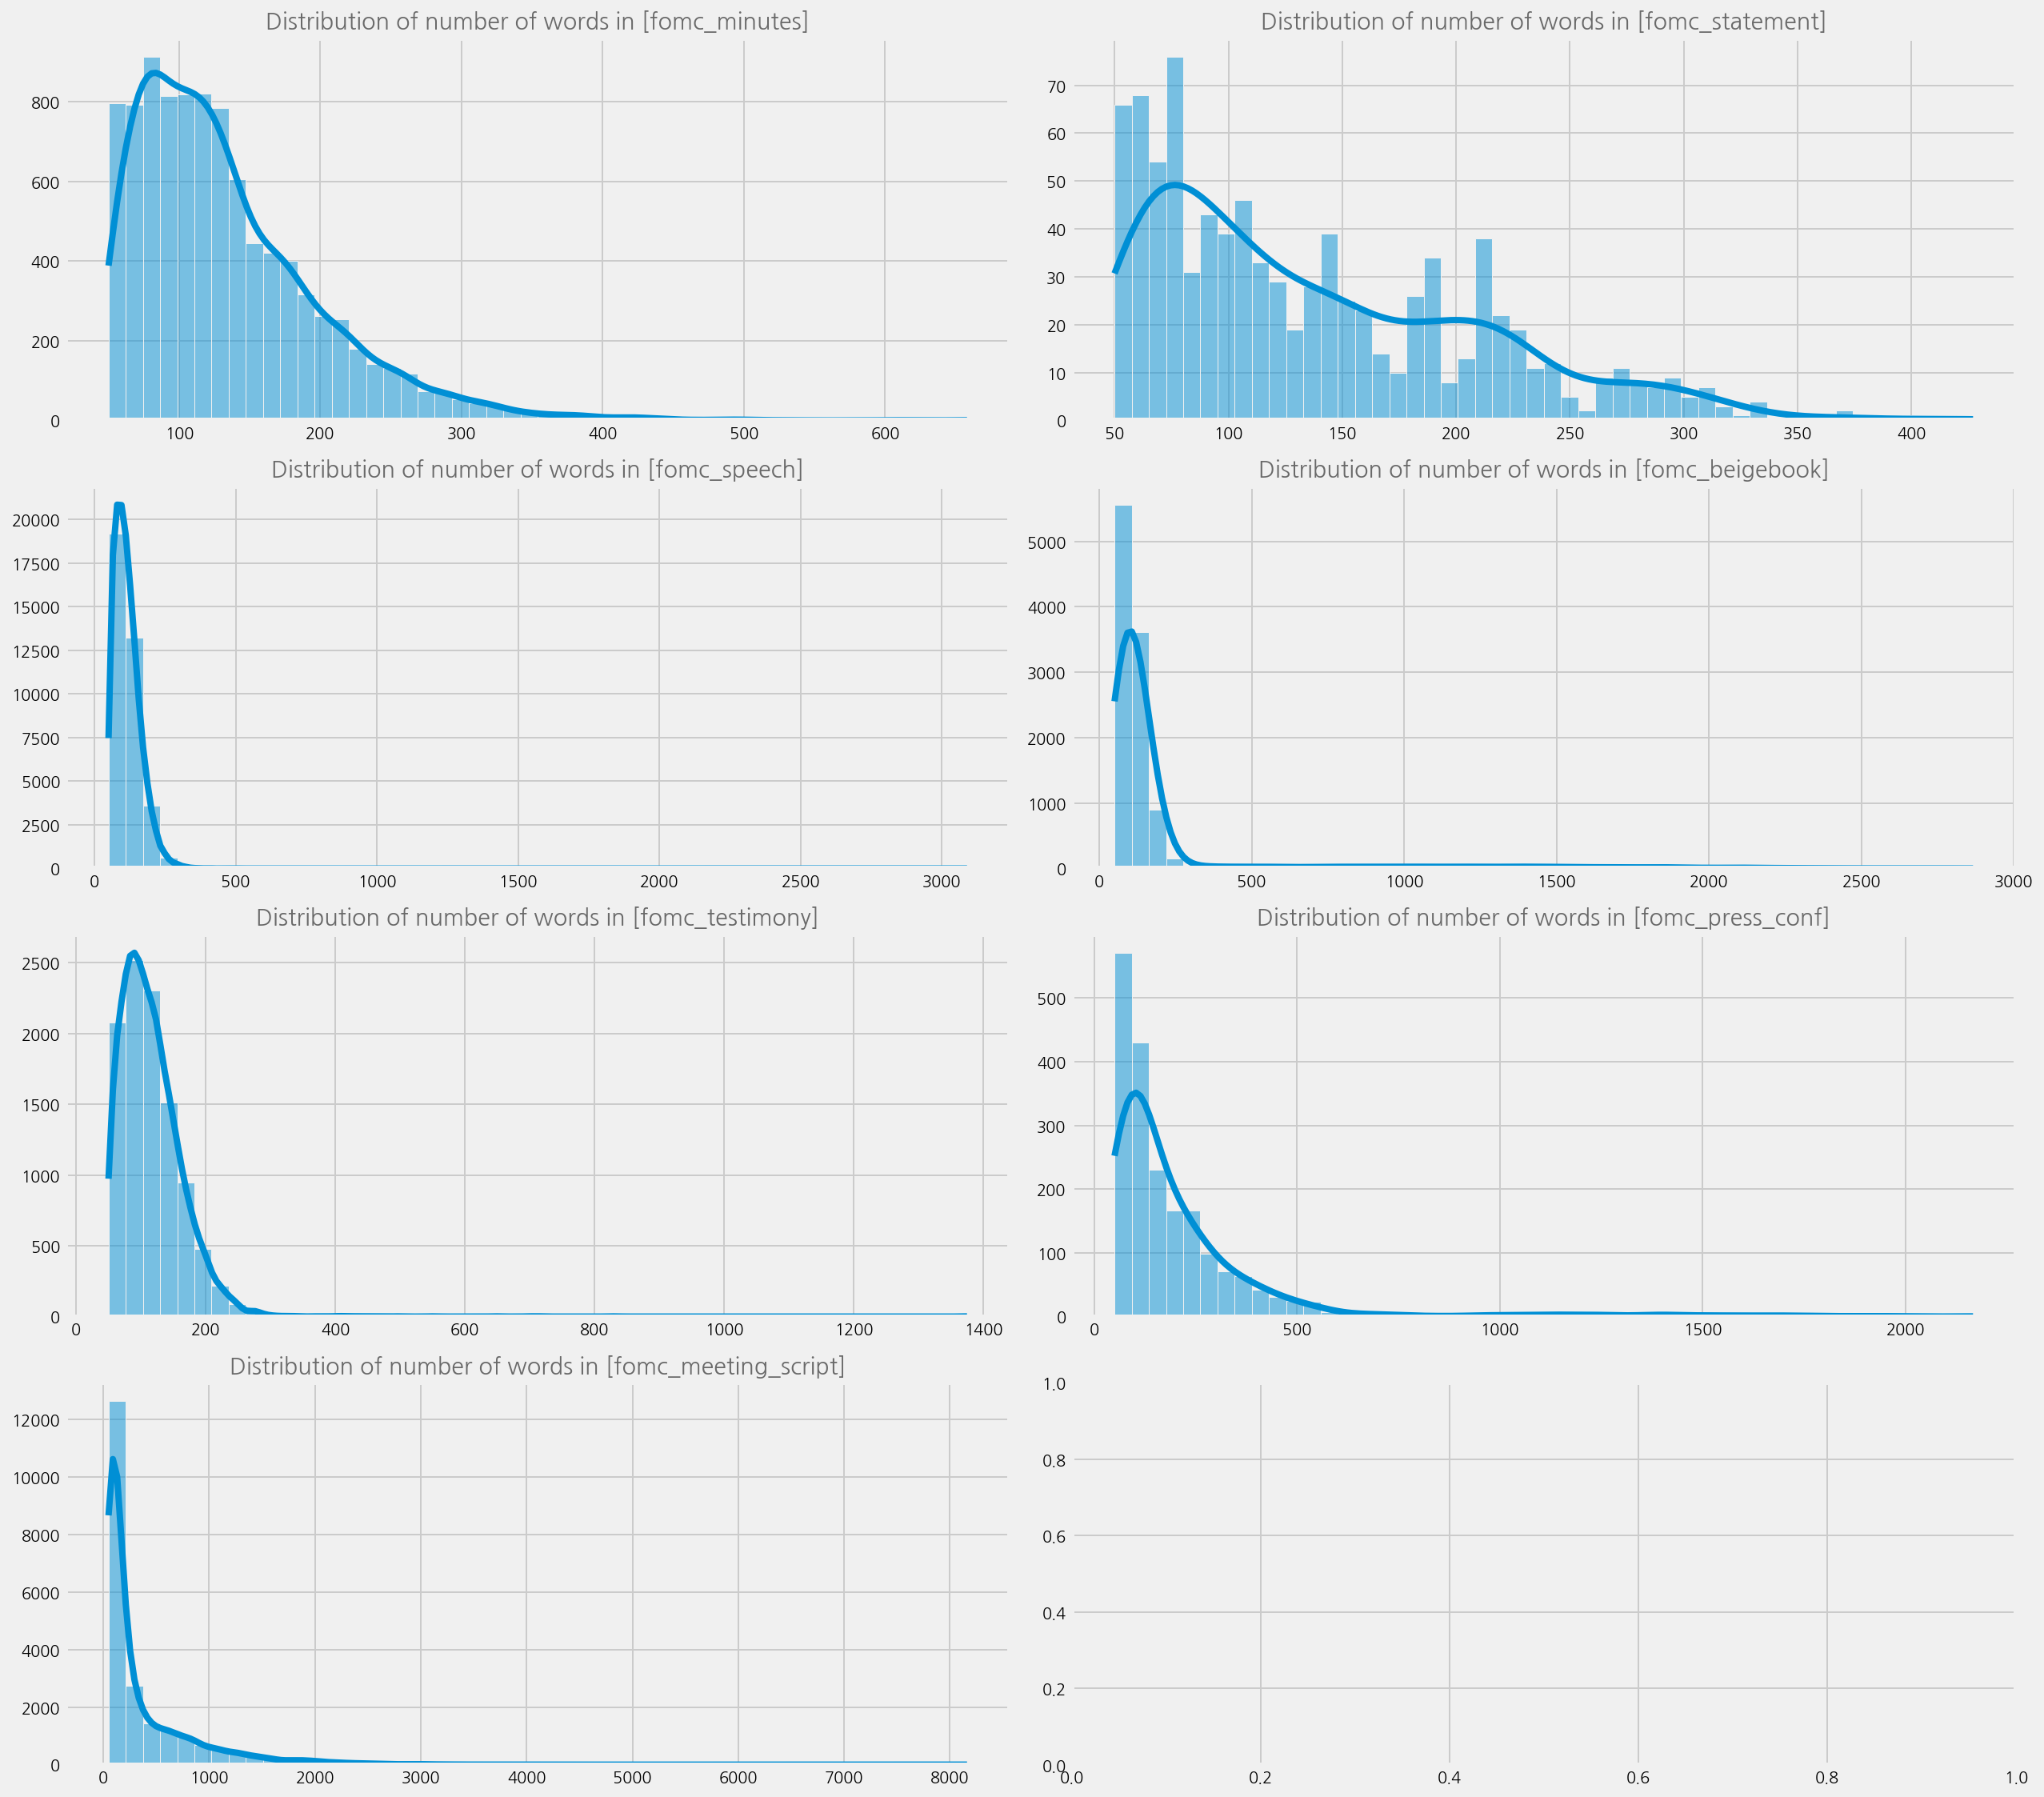

In [19]:
cfg = eKonf.compose("visualize/plot=histplot")
cfg.figure.figsize = (18, 16)
cfg.figure.fontsize = 10
cfg.subplots.ncols = 2
cfg.subplots.nrows = 4
ax = cfg.ax.copy()
histplot = cfg.histplot.copy()
histplot.x = "text_num_words"
histplot.bins = 50
histplot.kde = True
cfg.plots = [histplot.copy() for _ in range(len(content_types))]
cfg.axes = [ax.copy() for _ in range(len(content_types))]
for i, ctype in enumerate(content_types):
    plot = cfg.plots[i]
    plot.query = f"content_type == '{ctype}'"
    plot.axno = i
    ax = cfg.axes[i]
    ax.title =  f"Distribution of number of words in [{ctype}]"
    ax.axno = i

eKonf.instantiate(cfg, data=fomc_sections)

## Split sections into sentences

In [20]:
seg_cfg = eKonf.compose("preprocessor/segmenter=pysbd")

cfg = eKonf.compose("pipeline")
cfg.data_dir = data_dir
cfg.data_file = "fomc_sections.parquet"
cfg._pipeline_ = [
    "segment",
    "explode_splits",
    "filter_length",
    "reset_index",
    "save_dataframe",
]
cfg.segment.preprocessor.segmenter = seg_cfg
cfg.num_workers = 100
cfg.explode_splits.id_key = ["id", "section_id"]
cfg.explode_splits.split_key = "sent_id"
cfg.explode_splits.separator = "\n"
cfg.filter_length.min_length = 10
cfg.filter_length.max_length = 350
cfg.filter_length.len_func = "len_words"
cfg.filter_length.len_column = "num_words"
cfg.reset_index.drop_index = True
cfg.save_dataframe.output_dir = "../data/fomc"
cfg.save_dataframe.output_file = "fomc_sents.parquet"
fomc_sents = eKonf.instantiate(cfg)
fomc_sents.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sections.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_sections.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_sections.parquet
INFO:ekorpkit.pipelines.pipe:Applying pipeline: OrderedDict([('segment', 'segment'), ('explode_splits', 'explode_splits'), ('filter_length', 'filter_length'), ('reset_index', 'reset_index'), ('save_dataframe', 'save_dataframe')])
INFO:ekorpkit.base:Applying pipe: functools.partial(<function segment at 0x7fc2a666cb80>)
INFO:ekorpkit.pipelines.pipe:instantiating segmenter
INFO:ekorpkit.base:instantiating ekorpkit.preprocessors.segmenter.PySBDSegmenter...
INFO:ekorpkit.base:Using batcher with minibatch size: 921
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 921  procs: 100  input_split: False  merge_output: True  len(data): 92051 len(args): 5
Splitting column: text: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]
INFO:ekorpkit.pipeli

,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id
653463,2854,It will not have the word “somewhat” on line 3.,train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,10,287,2
653464,2854,Chair Yellen Yes Vice Chairman Dudley ...,train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,31,287,4
653465,2854,And let me confirm that the next meeting will ...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,19,288,3
653466,2854,I believe box lunches are now available for pe...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,33,288,4
653467,2854,"I will do my best, and I will consider at the ...",train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,18,288,5


In [21]:
fomc_sents = eKonf.load_data("fomc_sents.parquet", data_dir)
fomc_sents.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sents.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_sents.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_sents.parquet


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id
653463,2854,It will not have the word “somewhat” on line 3.,train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,10,287,2
653464,2854,Chair Yellen Yes Vice Chairman Dudley ...,train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,31,287,4
653465,2854,And let me confirm that the next meeting will ...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,19,288,3
653466,2854,I believe box lunches are now available for pe...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,33,288,4
653467,2854,"I will do my best, and I will consider at the ...",train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,18,288,5


INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/CountPlot.png


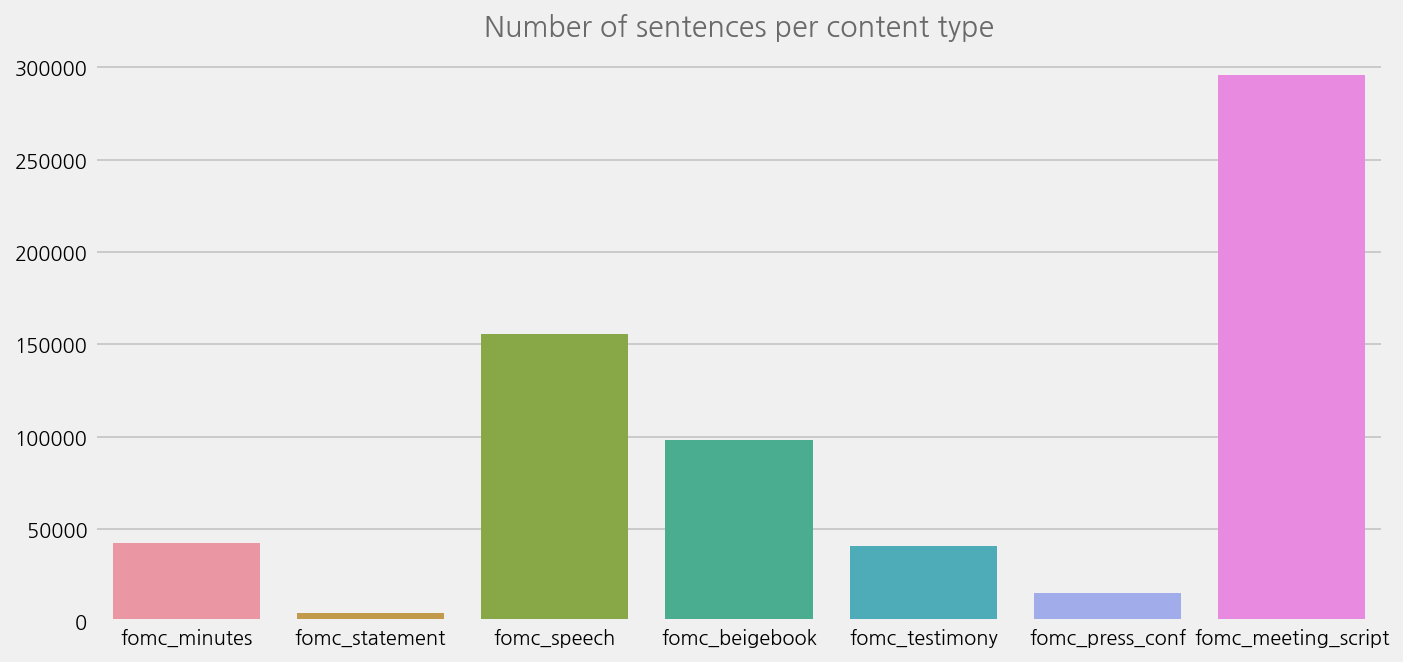

In [22]:
cfg = eKonf.compose("visualize/plot=countplot")
cfg.countplot.x = "content_type"
cfg.figure.figsize = (10, 5)
cfg.figure.fontsize = 10
cfg.ax.title = "Number of sentences per content type"
eKonf.instantiate(cfg, data=fomc_sents)

### Distribution of sentences

INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/HistPlot.png


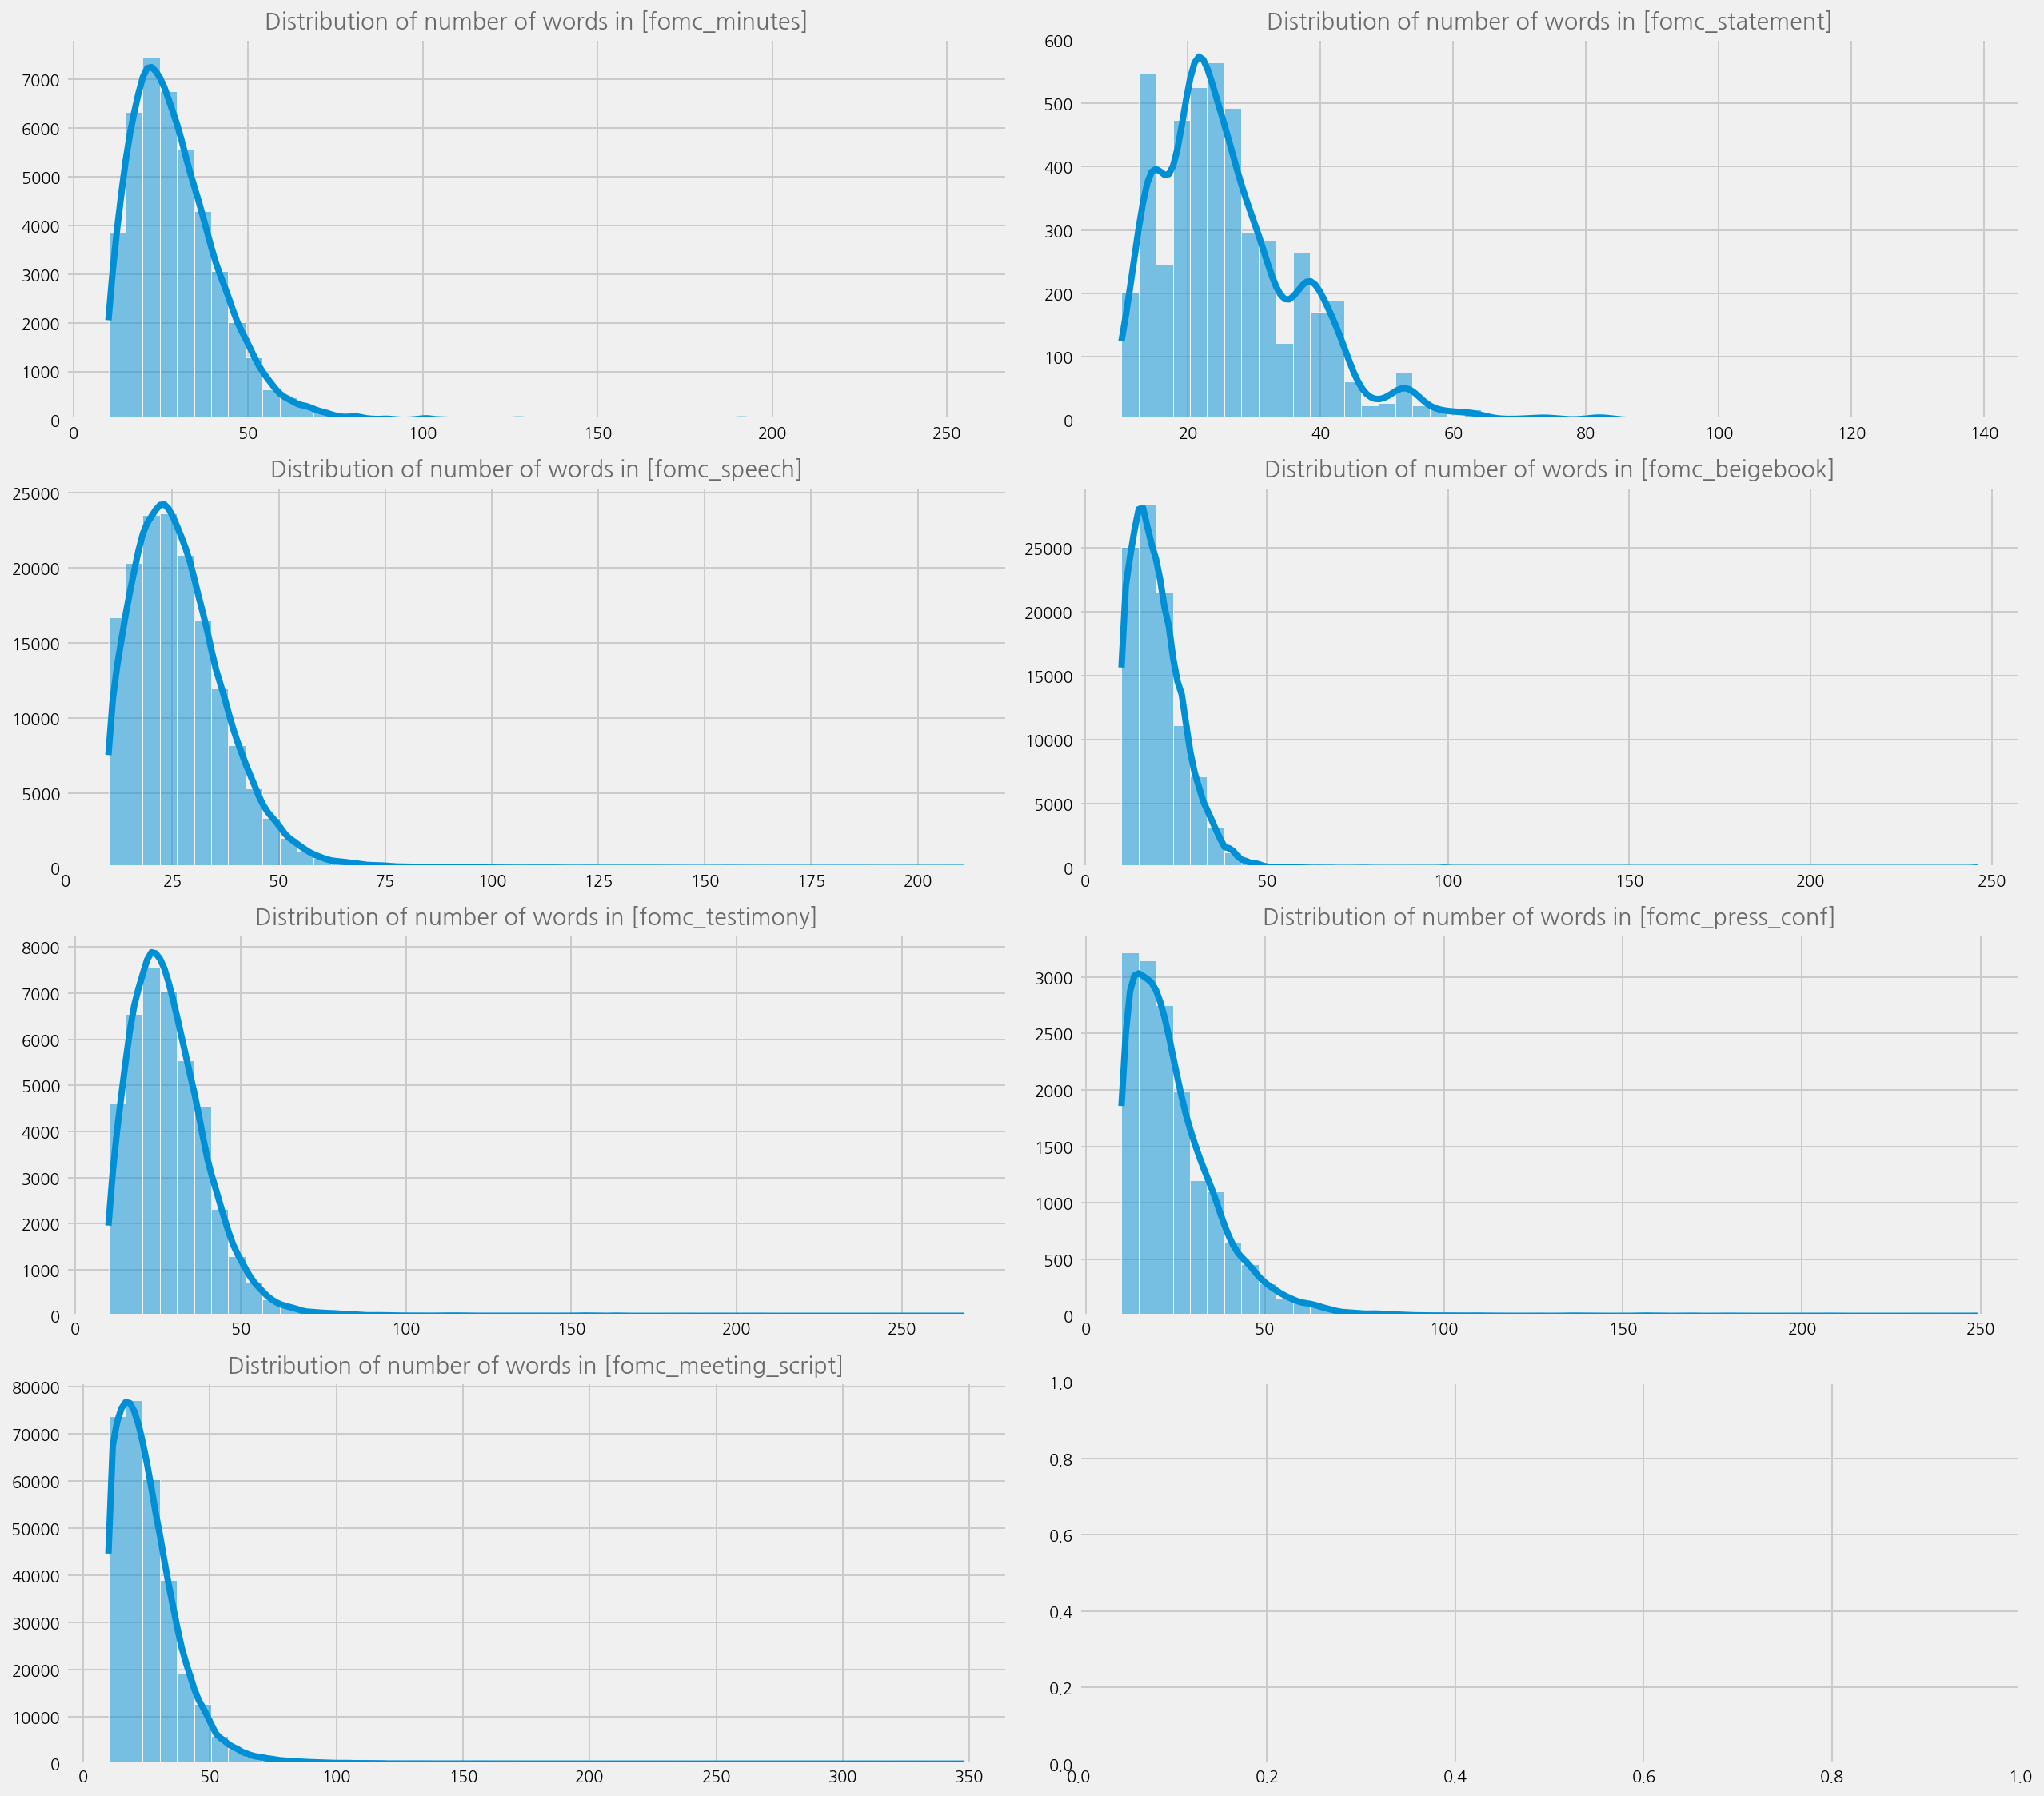

In [23]:
content_types = fomc_sents.content_type.unique()

cfg = eKonf.compose("visualize/plot=histplot")
cfg.figure.figsize = (18, 16)
cfg.figure.fontsize = 10
cfg.subplots.ncols = 2
cfg.subplots.nrows = 4
ax = cfg.ax.copy()
histplot = cfg.histplot.copy()
histplot.x = "text_num_words"
histplot.bins = 50
histplot.kde = True
cfg.plots = [histplot.copy() for _ in range(len(content_types))]
cfg.axes = [ax.copy() for _ in range(len(content_types))]
for i, ctype in enumerate(content_types):
    plot = cfg.plots[i]
    plot.query = f"content_type == '{ctype}'"
    plot.axno = i
    ax = cfg.axes[i]
    ax.title =  f"Distribution of number of words in [{ctype}]"
    ax.axno = i

eKonf.instantiate(cfg, data=fomc_sents)

## Split sections into chunks

In [24]:
seg_cfg = eKonf.compose("preprocessor/segmenter=pysbd")

cfg = eKonf.compose("pipeline")
cfg.data_dir = data_dir
cfg.data_file = "fomc_sections.parquet"
cfg._pipeline_ = [
    "segment",
    "chunk",
    "explode_splits",
    "filter_length",
    "reset_index",
    "save_dataframe",
]
cfg.segment.preprocessor.segmenter = seg_cfg
cfg.num_workers = 100
cfg.chunk.chunk_size = 200
cfg.chunk.len_func = "len_words"
cfg.explode_splits.id_key = ["id", "section_id"]
cfg.explode_splits.split_key = "chunk_id"
cfg.explode_splits.separator = "\n\n"
cfg.filter_length.min_length = 50
cfg.filter_length.max_length = 350
cfg.filter_length.len_func = "len_words"
cfg.filter_length.len_column = "num_words"
cfg.reset_index.drop_index = True
cfg.save_dataframe.output_dir = "../data/fomc"
cfg.save_dataframe.output_file = "fomc_chunks.parquet"
fomc_chunks = eKonf.instantiate(cfg)
fomc_chunks.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sections.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_sections.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_sections.parquet
INFO:ekorpkit.pipelines.pipe:Applying pipeline: OrderedDict([('segment', 'segment'), ('chunk', 'chunk'), ('explode_splits', 'explode_splits'), ('filter_length', 'filter_length'), ('reset_index', 'reset_index'), ('save_dataframe', 'save_dataframe')])
INFO:ekorpkit.base:Applying pipe: functools.partial(<function segment at 0x7fc2a666cb80>)
INFO:ekorpkit.pipelines.pipe:instantiating segmenter
INFO:ekorpkit.base:instantiating ekorpkit.preprocessors.segmenter.PySBDSegmenter...
INFO:ekorpkit.base:Using batcher with minibatch size: 921
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 921  procs: 100  input_split: False  merge_output: True  len(data): 92051 len(args): 5
Splitting column: text: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words,section_id,chunk_id
129101,2854,It also might help minimize the risks of the t...,train,2014-12-17,fomc_meeting_script,2014-12-17,VICE CHAIRMAN DUDLEY,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,172,285,6
129102,2854,Getting the right message on inflation is very...,train,2014-12-17,fomc_meeting_script,2014-12-17,VICE CHAIRMAN DUDLEY,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,158,285,7
129103,2854,CHAIR YELLEN. \nThank you. \nOkay. \nI thin...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,83,286,0
129104,2854,"MR. LUECKE. \nThis vote, as Chair Yellen indi...",train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,73,287,0
129105,2854,CHAIR YELLEN. \nOkay. \nThank you very much....,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,77,288,0


In [25]:
fomc_chunks = eKonf.load_data("fomc_chunks.parquet", data_dir)
fomc_chunks.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_chunks.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_chunks.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_chunks.parquet


,id,text,split,timestamp,content_type,date,speaker,title,decision,rate,recent_meeting,recent_decision,recent_rate,next_meeting,next_decision,next_rate,text_num_words,section_id,chunk_id
129101,2854,It also might help minimize the risks of the t...,train,2014-12-17,fomc_meeting_script,2014-12-17,VICE CHAIRMAN DUDLEY,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,172,285,6
129102,2854,Getting the right message on inflation is very...,train,2014-12-17,fomc_meeting_script,2014-12-17,VICE CHAIRMAN DUDLEY,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,158,285,7
129103,2854,CHAIR YELLEN. \nThank you. \nOkay. \nI thin...,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,83,286,0
129104,2854,"MR. LUECKE. \nThis vote, as Chair Yellen indi...",train,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,73,287,0
129105,2854,CHAIR YELLEN. \nOkay. \nThank you very much....,train,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2014-12-17,0.0,0.25,2015-01-28,0.0,0.25,77,288,0


INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/CountPlot.png


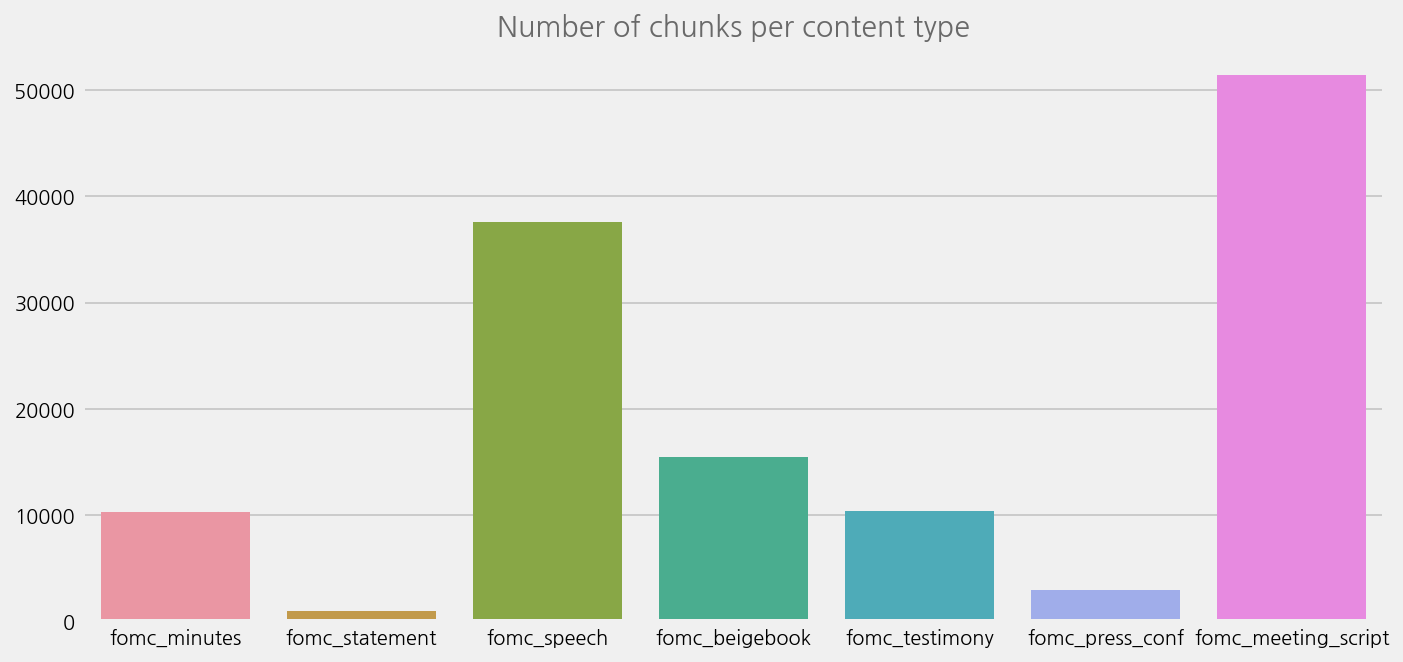

In [26]:
cfg = eKonf.compose("visualize/plot=countplot")
cfg.countplot.x = "content_type"
cfg.figure.figsize = (10, 5)
cfg.figure.fontsize = 10
cfg.ax.title = "Number of chunks per content type"
eKonf.instantiate(cfg, data=fomc_chunks)

### Distribution of chunks

INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.plot:Plotting histplot with {'x': 'text_num_words', 'bins': 50, 'kde': True}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/HistPlot.png


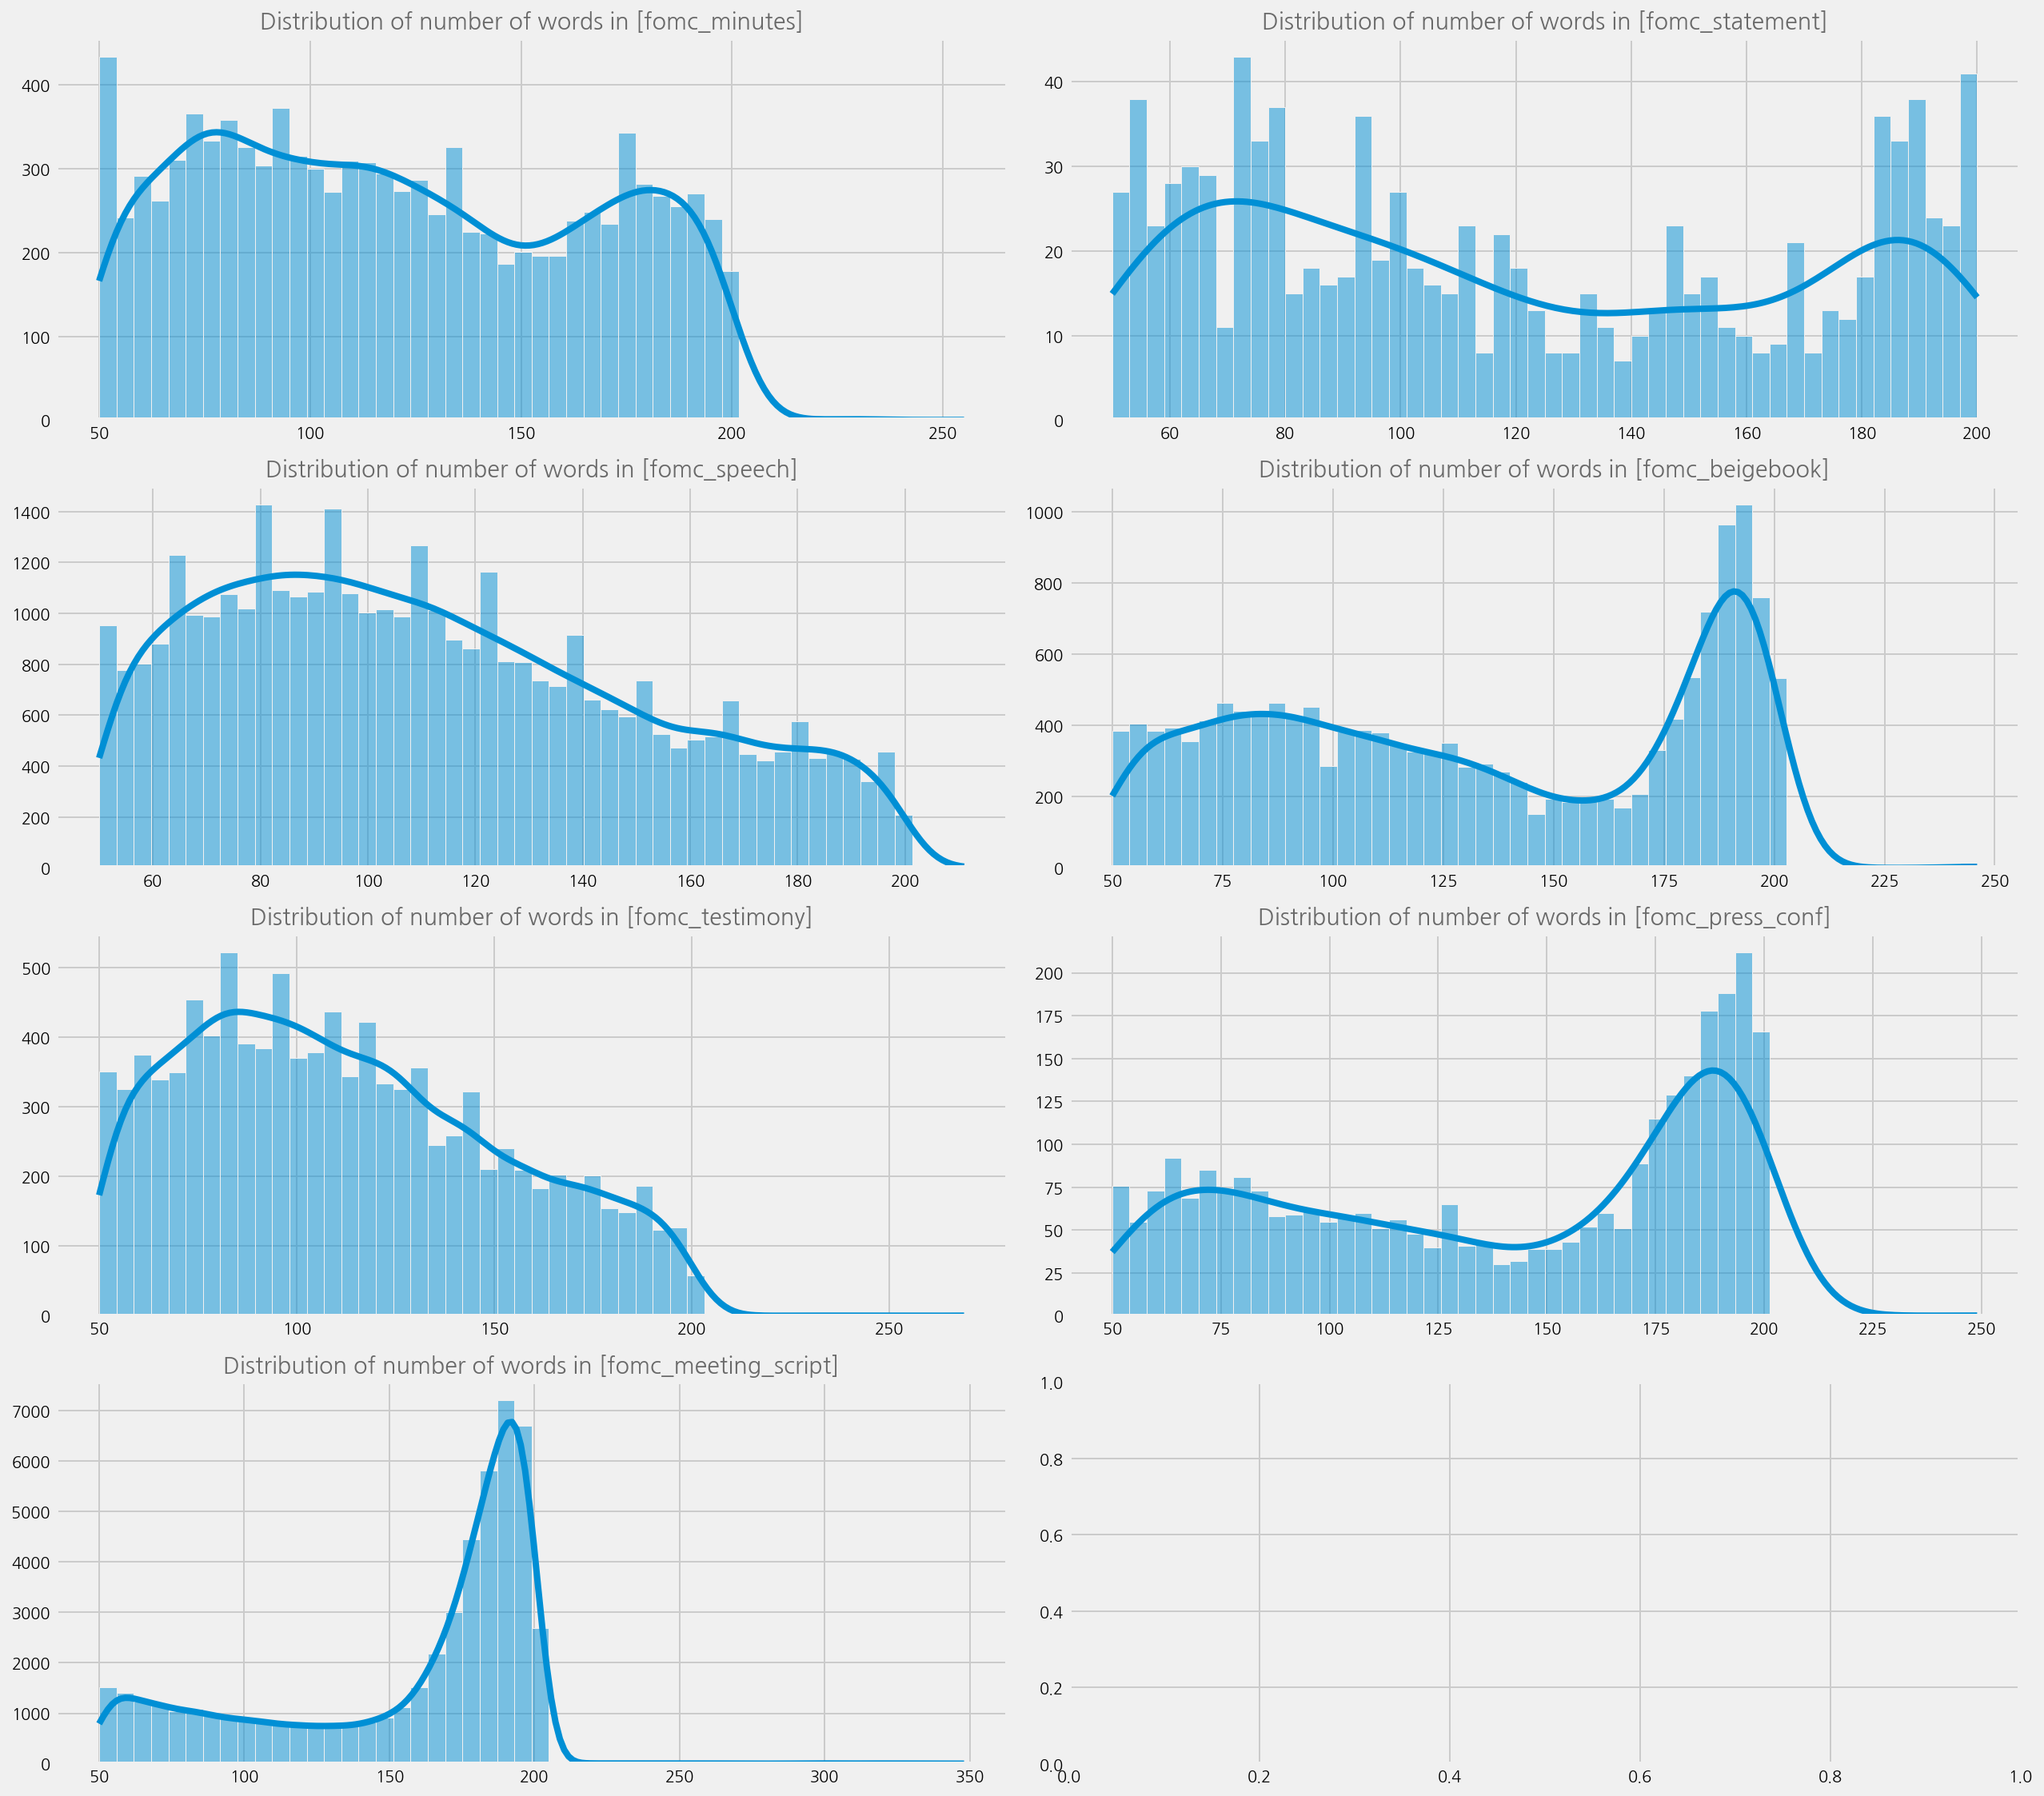

In [27]:
content_types = fomc_chunks.content_type.unique()

cfg = eKonf.compose("visualize/plot=histplot")
cfg.figure.figsize = (18, 16)
cfg.figure.fontsize = 10
cfg.subplots.ncols = 2
cfg.subplots.nrows = 4
ax = cfg.ax.copy()
histplot = cfg.histplot.copy()
histplot.x = "text_num_words"
histplot.bins = 50
histplot.kde = True
cfg.plots = [histplot.copy() for _ in range(len(content_types))]
cfg.axes = [ax.copy() for _ in range(len(content_types))]
for i, ctype in enumerate(content_types):
    plot = cfg.plots[i]
    plot.query = f"content_type == '{ctype}'"
    plot.axno = i
    ax = cfg.axes[i]
    ax.title =  f"Distribution of number of words in [{ctype}]"
    ax.axno = i

eKonf.instantiate(cfg, data=fomc_chunks)

### Compare number of records

INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.plot:Plotting countplot with {'x': 'content_type', 'hue': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/CountPlot.png


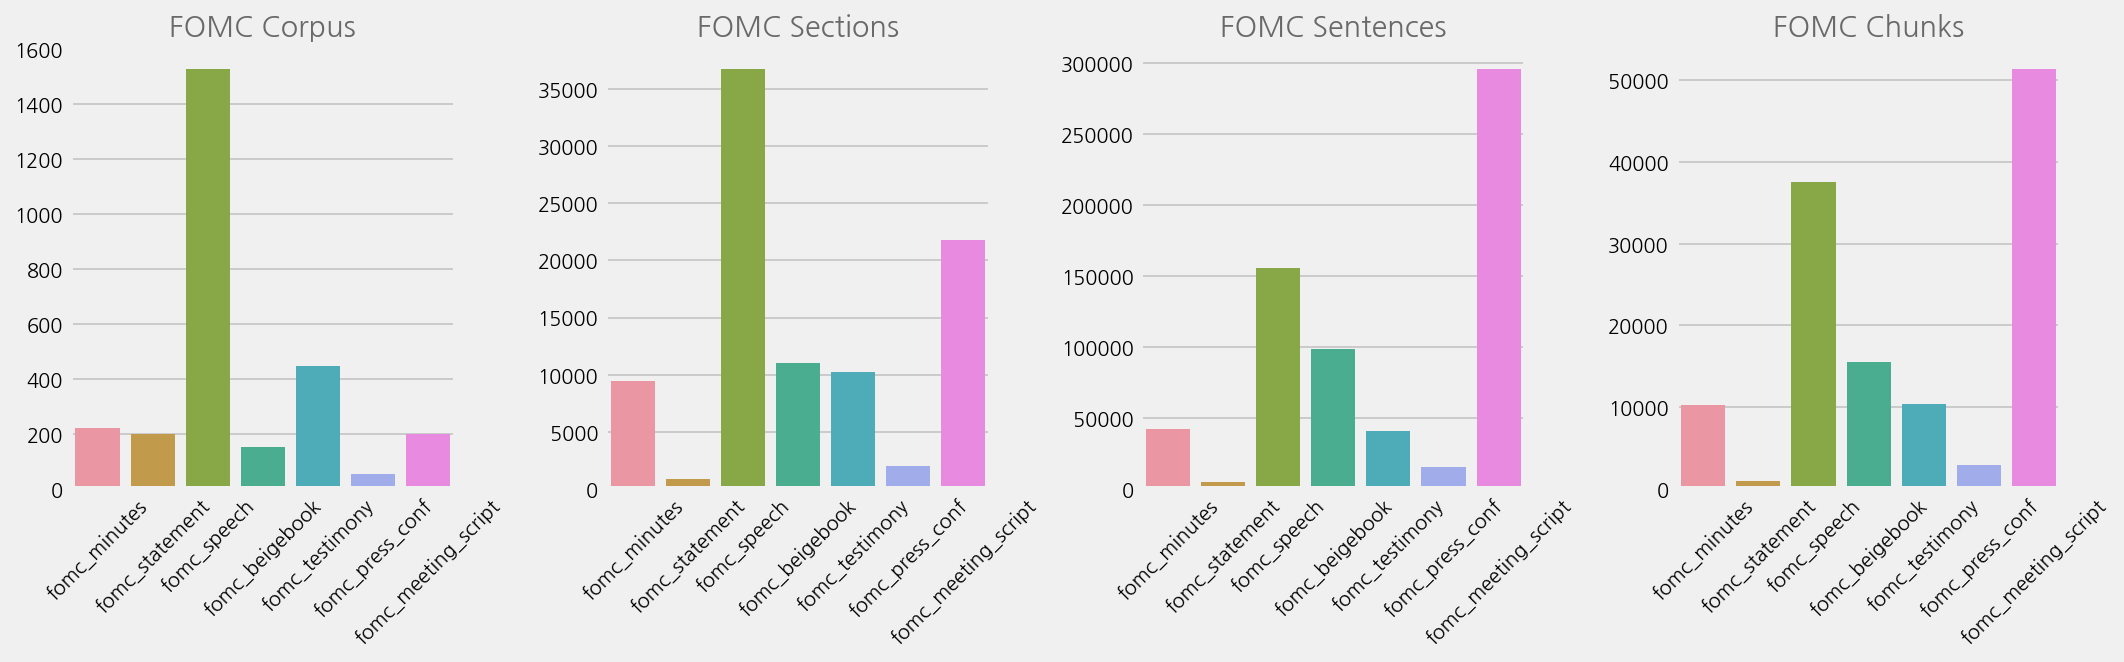

In [28]:
titles = ['FOMC Corpus', 'FOMC Sections', 'FOMC Sentences', 'FOMC Chunks']
cfg = eKonf.compose("visualize/plot=countplot")
cfg.figure.figsize = (15, 5)
cfg.figure.fontsize = 10
cfg.subplots.ncols = 4
cfg.subplots.nrows = 1
ax = cfg.ax.copy()
plot = cfg.plot.copy()
plot.x = "content_type"
cfg.plots = [plot.copy() for _ in range(4)]
cfg.axes = [ax.copy() for _ in range(4)]
for i in range(4):
    plot = cfg.plots[i]
    plot.axno = i
    plot.datano = i
    ax = cfg.axes[i]
    ax.title =  titles[i]
    ax.xtick_params = dict(labelrotation=45)
    ax.axno = i

eKonf.instantiate(cfg, data=[fomc_data, fomc_sections, fomc_sents, fomc_chunks])